### Importing modules:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tkl
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Add, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from itertools import chain

### Creating a list of file names:

In [ ]:
source_path = '../input/flickrfaceshq-dataset-ffhq'
filenames = []
filenames = list(glob.glob(source_path +  f'/*.png'))
random.shuffle(filenames)
filenames = filenames[:5000]

In [ ]:
print(len(filenames))

5000


### Showing a sample:

../input/flickrfaceshq-dataset-ffhq/46185.png


Text(0.5, 1.0, 'Noisy')

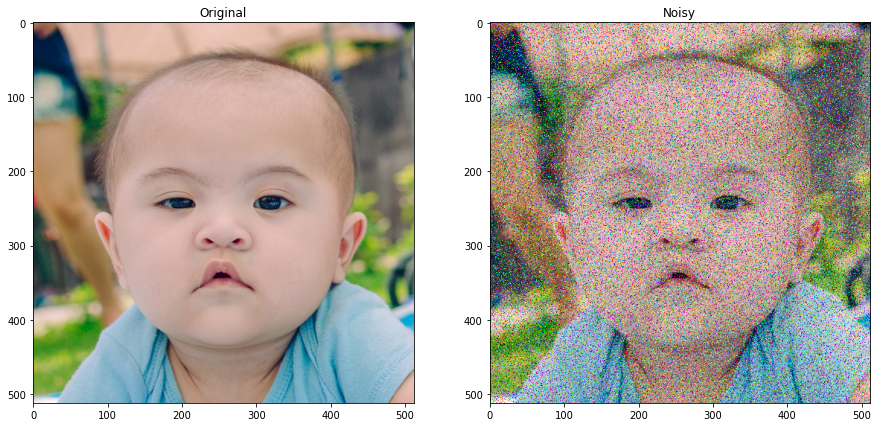

In [ ]:
img_path = filenames[1200]
print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
noisy = random_noise(img, mode = 's&p', amount=0.2)
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(noisy)
ax[1].set_title('Noisy')

### Creating train set and test set:

In [ ]:
test_filenames = filenames[-701:-1]
del filenames[-701:-1]
train_filenames = filenames
print(f'Size of training set is: {len(train_filenames)}', end='\n----------------------------\n')
print(f'Size of test set is: {len(test_filenames)}', end='\n----------------------------\n')

Size of training set is: 4300
----------------------------
Size of test set is: 700
----------------------------


### Train set and validation set:

In [ ]:
train_img, val_img, _, _ = train_test_split(train_filenames, train_filenames, test_size = 0.1, shuffle = True, random_state = 0)

In [ ]:
print(f'Size of training set is: {len(train_img)}', end='\n----------------------------\n')
print(f'Size of validation set is: {len(val_img)}', end='\n----------------------------\n')
print(f'Total: {len(train_img) + len(val_img)}')

Size of training set is: 3870
----------------------------
Size of validation set is: 430
----------------------------
Total: 4300


### Determining important variables:

In [ ]:
WIDTH = 512
HEIGHT = 512
n_channels = 3
BATCH_SIZE = 16

### Data generation:

In [ ]:
class  DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, original_filenames, batch_size = BATCH_SIZE, shuffle = True):
        self.original_filenames = original_filenames
        self.noisy_filenames = original_filenames
        self.filenames = list(zip(self.original_filenames, self.noisy_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
    
    def __len__(self):
        return (len(self.original_filenames) // self.batch_size)
    
    def __getitem__(self, idx):
        batch = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, Y = self.__data_generation(batch)

        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.original_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch):
        original = []
        noisy = []
        
        for original_filename, _ in batch:
          image = cv2.imread(original_filename) / 255
          image = cv2.resize(image, (WIDTH, HEIGHT))
          original.append(image)
          noisy.append(self.make_noisy(image))
          
        return  np.array(noisy), np.array(original)

    def make_noisy(self, image):
      image_ = image
      noisy_image = random_noise(image_, mode = 's&p', amount = 0.2)
      
      return noisy_image

### Generating training set and validation set:

In [ ]:
train_generator = DataGenerator(train_img, BATCH_SIZE)
val_generator = DataGenerator(val_img, BATCH_SIZE)

### Creating the model architecture (U-net):

In [ ]:
def conv_blocks_maker(inputs=None, n_filters=32, kernel_size=(3,3), padding='same'):
    
    # First layer
    
    conv = tkl.Conv2D(filters = n_filters,
                      kernel_size = kernel_size,
                      padding = padding,
                      kernel_initializer = 'he_normal')(inputs)
    
    conv = tkl.Activation('relu')(conv)
    
    
    # Second layer
    
    conv = tkl.Conv2D(filters = n_filters,
                     kernel_size = kernel_size,
                     padding = padding,
                     kernel_initializer = 'he_normal')(conv)
    
    conv = tkl.Activation('relu')(conv)
    
    return conv


def pool_maker(skip, pool_size=(2,2), dropout_prob=0.1):
    conv = tkl.MaxPooling2D(pool_size)(skip)
    conv = tkl.Dropout(dropout_prob)(conv)
    
    return conv


def upsampler(conv, block_size, num_filters):  
    
    # Sub-pixel convolution
    conv = Conv2D(num_filters * (block_size ** 2), (3,3), padding='same')(conv)
    
    # Pixel shuffle
    conv =  pixel_shuffle(block_size)(conv)    
    
    return conv


def pixel_shuffle(block_size):
    return lambda conv: tf.nn.depth_to_space(conv, block_size)


def decoder(conv, skip, block_size, n_filters, kernel_size, conv_blocks):
    pixel_shuffle = upsampler(conv, block_size, n_filters)
    concatenated = concatenate([skip, pixel_shuffle])
        
    if (conv_blocks == True):
        conv = conv_blocks_maker(concatenated, n_filters, kernel_size)
    else:
        conv = Conv2D(n_filters, (3,3), padding='same',
                      activation = 'relu')(concatenated)
    
    return conv

In [ ]:
def unet_model_creator(n_filters=32, dropout_prob=0.1):
    
    # Encoder part
    
    input_size = (WIDTH, HEIGHT, n_channels)
    
    input_img = tf.keras.Input(input_size, name = 'image' )
    skip_1 = conv_blocks_maker(input_img, n_filters / 2, kernel_size = 3)
    
    conv = pool_maker(skip_1)
    skip_2 = conv_blocks_maker(conv, n_filters, kernel_size = 3)
    
    conv = pool_maker(skip_2)
    skip_3 = conv_blocks_maker(conv, n_filters * 2, kernel_size = 3)
    
    conv = pool_maker(skip_3)
    skip_4 = conv_blocks_maker(conv, n_filters * 4, kernel_size = 3)
    
    conv = pool_maker(skip_4)
    skip_5 = conv_blocks_maker(conv, n_filters * 8 , kernel_size = 3)
    
    conv = pool_maker(skip_5)
    conv = conv_blocks_maker(conv, n_filters * 16 , kernel_size = 3)
    

    # Decoder part
    
    decoded_layer = decoder(conv, skip_5, block_size=2,
                            n_filters=256, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_4, block_size=2,
                            n_filters=128, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_3, block_size=2,
                            n_filters=64, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_2, block_size=2,
                            n_filters=32, kernel_size=(3,3),
                            conv_blocks=True)
    
    decoded_layer = decoder(decoded_layer, skip_1, block_size=2,
                            n_filters=16, kernel_size=(3,3),
                            conv_blocks=False)

    output = Conv2D(3, (1,1), activation='sigmoid')(decoded_layer)

    model = tf.keras.Model(inputs = [input_img], outputs = [output])
    
    return model

In [ ]:
model = unet_model_creator()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 512, 512, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 512, 512, 16) 0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 512, 512, 16) 2320        activation_20[0][0]              
____________________________________________________________________________________________

### Compiling the model:

In [ ]:
adam = Adam(learning_rate = 0.003)
model.compile(optimizer = adam, loss = 'mse', metrics = ['accuracy'])

### Training the model:

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    use_multiprocessing = True,
                    workers = 6, epochs=20)

2022-02-09 09:08:03.994224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-09 09:08:17.626044: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


241/241 [==============================] - 350s 1s/step - loss: 0.0128 - accuracy: 0.7441 - val_loss: 0.0041 - val_accuracy: 0.7749
Epoch 2/20
241/241 [==============================] - 335s 1s/step - loss: 0.0034 - accuracy: 0.8013 - val_loss: 0.0032 - val_accuracy: 0.8177
Epoch 3/20
241/241 [==============================] - 341s 1s/step - loss: 0.0028 - accuracy: 0.8291 - val_loss: 0.0026 - val_accuracy: 0.8271
Epoch 4/20
241/241 [==============================] - 339s 1s/step - loss: 0.0025 - accuracy: 0.8463 - val_loss: 0.0023 - val_accuracy: 0.8645
Epoch 5/20
241/241 [==============================] - 338s 1s/step - loss: 0.0022 - accuracy: 0.8629 - val_loss: 0.0021 - val_accuracy: 0.8780
Epoch 6/20
241/241 [==============================] - 338s 1s/step - loss: 0.0022 - accuracy: 0.8674 - val_loss: 0.0022 - val_accuracy: 0.8684
Epoch 7/20
241/241 [==============================] - 338s 1s/step - loss: 0.0020 - accuracy: 0.8762 - val_loss: 0.0020 - val_accuracy: 0.8684
Epoch 8/20

### Saving the model:

In [ ]:
model.save('FinalDenoiser_kaggle.h5')

### Evaluating the model:

In [ ]:
test_generator = DataGenerator(test_filenames, BATCH_SIZE)
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

43/43 [==============================] - 42s 977ms/step - loss: 0.0013 - accuracy: 0.9096
test loss, test acc: [0.0012524062767624855, 0.9095511436462402]


### Testing the model:

In [ ]:
path = test_filenames[60]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))
noisy = random_noise(img, mode = 's&p', amount=0.1)
expanded = tf.expand_dims(noisy, axis=0)
predicted = model.predict(expanded)
predicted = tf.squeeze(predicted, axis=0)

Text(0.5, 1.0, 'original')

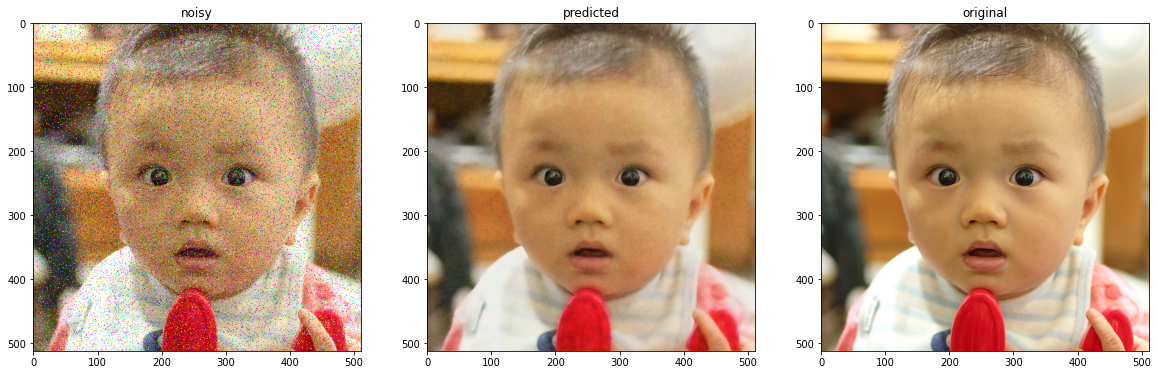

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(noisy)
ax[0].set_title('noisy')
ax[1].imshow(predicted)
ax[1].set_title('predicted')
ax[2].imshow(img)
ax[2].set_title('original')